In [11]:
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from sklearn.metrics import classification_report, auc, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import sys
sys.path.append("../")
from src.utils import pr_auc_macro

# RANDOMIZED SEARCH

In [29]:
generated_features_df = pd.read_parquet("../preprocessed/generated_features.parquet")
X = generated_features_df.drop(["target"], axis=1)
y = generated_features_df['target'].to_numpy()

In [33]:
data = X.drop(["categories1", "variantid1", "variantid2"], axis=1)

grid = {'grow_policy' : ['SymmetricTree', 'Depthwise', 'Lossguide'],
        'leaf_estimation_method' : ['Newton', 'Gradient'],
        'bagging_temperature' : [0, 1, 2],
        'l2_leaf_reg': [1, 3, 5, 7],
        'random_strength' : [0, 1, 2]}

model = CatBoostClassifier(iterations=3000, loss_function='Logloss', eval_metric='PRAUC')

rs_result = model.randomized_search(
    grid, X=data,y=y, 
    plot=True,
    verbose=True,
    stratified=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7555628	test: 0.7569937	best: 0.7569937 (0)	total: 378ms	remaining: 18m 53s
1:	learn: 0.7669619	test: 0.7685915	best: 0.7685915 (1)	total: 675ms	remaining: 16m 52s
2:	learn: 0.7691960	test: 0.7712135	best: 0.7712135 (2)	total: 936ms	remaining: 15m 35s
3:	learn: 0.7696612	test: 0.7716678	best: 0.7716678 (3)	total: 1.18s	remaining: 14m 45s
4:	learn: 0.7729387	test: 0.7748989	best: 0.7748989 (4)	total: 1.51s	remaining: 15m 7s
5:	learn: 0.7721377	test: 0.7740333	best: 0.7748989 (4)	total: 1.85s	remaining: 15m 24s
6:	learn: 0.7756172	test: 0.7774906	best: 0.7774906 (6)	total: 2.14s	remaining: 15m 15s
7:	learn: 0.7773130	test: 0.7795916	best: 0.7795916 (7)	total: 2.36s	remaining: 14m 43s
8:	learn: 0.7813275	test: 0.7838653	best: 0.7838653 (8)	total: 2.65s	remaining: 14m 42s
9:	learn: 0.7822317	test: 0.7846648	best: 0.7846648 (9)	total: 2.88s	remaining: 14m 22s
10:	learn: 0.7830950	test: 0.7858389	best: 0.7858389 (10)	total: 3.38s	remaining: 15m 19s
11:	learn: 0.7832457	test: 0.78

In [35]:
rs_result['params']

{'bagging_temperature': 0,
 'random_strength': 2,
 'l2_leaf_reg': 7,
 'grow_policy': 'Depthwise',
 'leaf_estimation_method': 'Gradient'}

# SPLIT. FIT. PREDICT

In [37]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

In [38]:
train_pool = Pool(
    data=X_train.drop(['categories1', "variantid1", "variantid2"], axis=1),
    label=y_train,
)
eval_pool = Pool(
    data=X_test.drop(['categories1', "variantid1", "variantid2"], axis=1),
    label=y_test,
)

In [39]:
model = CatBoostClassifier(iterations=3000, loss_function='Logloss', eval_metric='PRAUC', **rs_result['params'])

model.fit(
    train_pool,
    eval_set=eval_pool,
    plot=True,
    verbose=True,
    use_best_model=True,
    early_stopping_rounds=50,
    metric_period=50
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7682724	test: 0.7662151	best: 0.7662151 (0)	total: 946ms	remaining: 47m 17s
50:	learn: 0.8196534	test: 0.8172032	best: 0.8172032 (50)	total: 24.1s	remaining: 23m 11s
100:	learn: 0.8329407	test: 0.8298301	best: 0.8298301 (100)	total: 49.6s	remaining: 23m 43s
150:	learn: 0.8401818	test: 0.8365134	best: 0.8365134 (150)	total: 1m 13s	remaining: 23m 12s
200:	learn: 0.8445778	test: 0.8403187	best: 0.8403187 (200)	total: 1m 35s	remaining: 22m 10s
250:	learn: 0.8480616	test: 0.8433753	best: 0.8433753 (250)	total: 1m 56s	remaining: 21m 13s
300:	learn: 0.8506576	test: 0.8455526	best: 0.8455526 (300)	total: 2m 19s	remaining: 20m 48s
350:	learn: 0.8530339	test: 0.8475014	best: 0.8475014 (350)	total: 2m 41s	remaining: 20m 19s
400:	learn: 0.8553304	test: 0.8491612	best: 0.8491612 (400)	total: 3m 3s	remaining: 19m 50s
450:	learn: 0.8581661	test: 0.8509998	best: 0.8509998 (450)	total: 3m 26s	remaining: 19m 26s
500:	learn: 0.8616580	test: 0.8530648	best: 0.8530648 (500)	total: 3m 48s	remain

In [40]:
preds = model.predict(X_test.drop(["categories1", "variantid1", "variantid2"], axis=1))
similarities = model.predict_proba(X_test.drop(["categories1", "variantid1", "variantid2"], axis=1))

In [41]:
X_test['target'] = y_test
X_test['scores'] = similarities[:, 1]
y_val = X_test[[ 'target', 'variantid1', 'variantid2']]
X_val = X_test[['categories1', 'scores', 'variantid1', 'variantid2']]

In [42]:
pr_auc_macro(target_df=y_val, predictions_df=X_val, cat_column='categories1')

0.5826780715411807

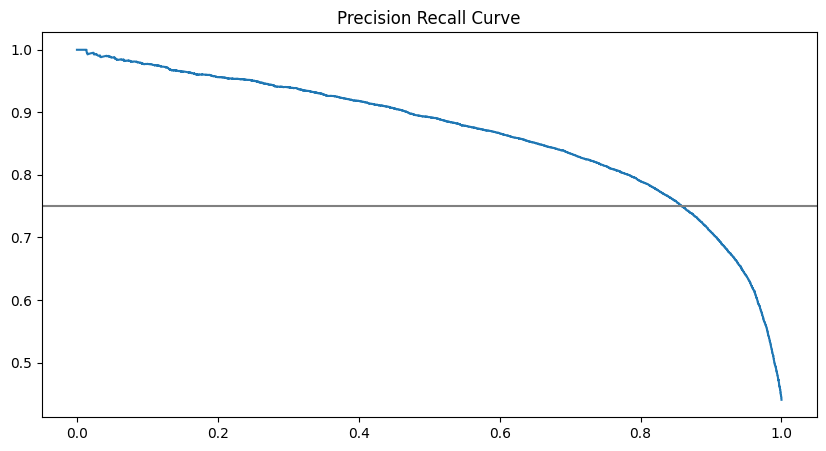

In [43]:
precision, recall, thrs = precision_recall_curve(y_test, X_test['scores'].to_numpy())
pr_auc = auc(recall, precision)

fig, ax = plt.subplots(1, figsize=(10, 5))

ax.plot(recall, precision)
ax.axhline(y=0.75, color='grey', linestyle='-')
ax.set_title("Precision Recall Curve")
plt.show()

In [44]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.84      0.83      0.84     34305
         1.0       0.79      0.80      0.80     27003

    accuracy                           0.82     61308
   macro avg       0.82      0.82      0.82     61308
weighted avg       0.82      0.82      0.82     61308

